In [47]:
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno

In [2]:
DATA_PATH = '/opt/ml/input/data/'
train = pd.read_csv(DATA_PATH+'train_data.csv', parse_dates=['Timestamp'])
test = pd.read_csv(DATA_PATH+'test_data.csv', parse_dates=['Timestamp'])
sub = pd.read_csv(DATA_PATH+'sample_submission.csv')

train = train.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)
test = test.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [3]:
train['seconds'] = train['Timestamp'].copy().apply(lambda x: x.timestamp())

In [5]:
diff = train.loc[:, ['userID', 'seconds']].groupby('userID').diff(periods=-1)
train['seconds'] = diff['seconds'].apply(abs)
train['seconds'].describe()

count    2.259888e+06
mean     5.284207e+04
std      4.052671e+05
min      0.000000e+00
25%      1.300000e+01
50%      3.700000e+01
75%      1.360000e+02
max      2.560230e+07
Name: seconds, dtype: float64

In [6]:
train['seconds'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2266586 entries, 0 to 2266585
Series name: seconds
Non-Null Count    Dtype  
--------------    -----  
2259888 non-null  float64
dtypes: float64(1)
memory usage: 17.3 MB


In [8]:
def percentile(s):
    return np.sum(s) / len(s)

def minsum(s):
    a = np.sort(s)
    if a[0] == 0:
        a[0] = 1
    ans = 0
    length = 0
    for i in a:
        if i>a[0]*5:
            break
        ans += i
        length += 1
    return ans / length

In [10]:
time_groupyby = train.groupby(['answerCode','assessmentItemID']).agg({
    'userID': 'count',
    'seconds': minsum
})
time_groupyby = time_groupyby.loc[1].reset_index().sort_values(by='seconds')
time_groupyby

,assessmentItemID,userID,seconds
8274,A080051006,171,0.333333
7684,A070138006,58,0.500000
7542,A070119008,40,0.500000
8152,A080035008,39,0.500000
8484,A080079008,153,0.555556
...,...,...,...
4002,A040183005,30,453.000000
2660,A030125005,74,562.250000
3056,A030198005,25,764.000000
1854,A020168005,26,768.500000


In [13]:
assess_groupby = train.groupby('assessmentItemID').agg({
    'userID': 'count',
    'answerCode': 'mean'
})
assess_groupby = assess_groupby.reset_index()
assess_groupby

,assessmentItemID,userID,answerCode
0,A010001001,317,0.930599
1,A010001002,317,0.958991
2,A010001003,317,0.905363
3,A010001004,317,0.949527
4,A010001005,317,0.886435
...,...,...,...
9449,A090074002,45,0.444444
9450,A090074003,45,0.577778
9451,A090074004,45,0.333333
9452,A090074005,45,0.400000


In [24]:
assess_groupby['assessmentItemID'] = assess_groupby['assessmentItemID'].astype(str)

In [25]:
time_groupyby['assessmentItemID'] = time_groupyby['assessmentItemID'].astype(str)

In [27]:
time_groupyby['assessmentItemID'].dtype

dtype('O')

In [28]:
assess_groupby['assessmentItemID'].dtype

dtype('O')

In [36]:
merged_time_ass = time_groupyby.merge(assess_groupby,on='assessmentItemID')[['assessmentItemID','seconds','answerCode']]
merged_time_ass

,assessmentItemID,seconds,answerCode
0,A080051006,0.333333,0.467213
1,A070138006,0.500000,0.320442
2,A070119008,0.500000,0.178571
3,A080035008,0.500000,0.433333
4,A080079008,0.555556,0.426184
...,...,...,...
9449,A040183005,453.000000,0.326087
9450,A030125005,562.250000,0.277154
9451,A030198005,764.000000,0.531915
9452,A020168005,768.500000,0.187050


Text(0, 0.5, 'Mean Seconds of correct answers')

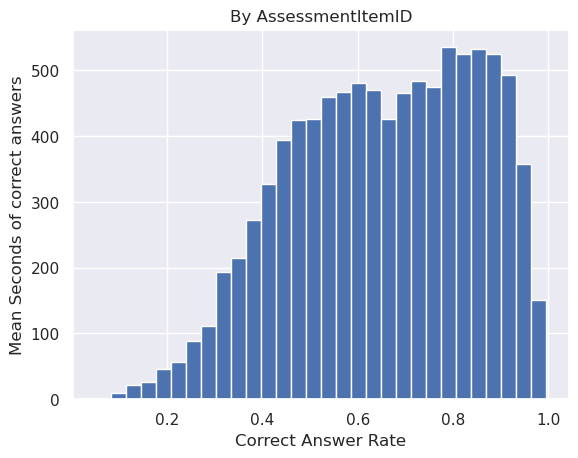

In [87]:
fig, ax = plt.subplots()

merged_time_ass.set_index('seconds')['answerCode'].hist(bins=30, ax=ax)

ax.set_title('By AssessmentItemID')
ax.set_xlabel('Correct Answer Rate')
ax.set_ylabel('Mean Seconds of correct answers')